### RNN Model for Stock Analysis

1. import data from csv datsets
    - prices
    - sector and industry 
    - revenue
    - profit
2. compile into timestep sequence
3. create lagged y-value set
4. create model
    - lstm cell
    - dense layer
    - consider another lstm and dense layer
    - output
5. run model based on following inputs for each time step
    - market cap
    - industry (one-hot vector)
    - sector (one-hot vector)
    - revenue
    - profit
6. predict
    - run model up until the known value is done
    - iterate through following values feeding previous output and hidden state

#### Initialize definitions

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

# using tensorflow.keras may be necessary, keras by itself may not work
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, TimeDistributed, Reshape, Dropout
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K

In [33]:
# define constants and filepaths

shareprices_path = 'us-shareprices-daily.csv'
# shareprices_path = 'us-shareprices-latest.csv' # latest data only, helps shorten load time while developing

MAX_DAYS = 9000 # number of total days possible for a stock
T_x = 180 # number of timesteps
T_y = 1 # number of outputs, T_x = T_y, or 1, depending on the architecture
n_a = 64 # number of hidden activation units
n_values = 1 # number of output predicted variables
n_trailing = T_x # number of trailing days used for prediction
n_lag = 15 # number of timesteps in advance for forward prediction
m = 1500 # number of training examples

sc = MinMaxScaler(feature_range=(0,1))

In [3]:
# load prices of shares from the daily share price values
# for with open as f documentation, see https://likegeeks.com/numpy-loadtxt-tutorial

with open(shareprices_path) as f:
    cols = f.readline().split(';')
    sample = f.readline().split(';')

# identify columns of interest and indices

col_names = ['Ticker', 'SimFinId', 'Date', '"Adj. Close"', '"Shares Outstanding"\n']
col_nums = []
for name in col_names:
    col_nums.append(cols.index(name))
col_names = ['Ticker', 'SimFinId', 'Date', 'Price', 'Shares']
    
# for cols.index documentation, see https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-list
# using np.genfromtxt instead of np.loadtxt because more flexibility with datatype (and no issue with floats)

prices = np.genfromtxt(open(shareprices_path), 
                    delimiter=';', 
                    skip_header=1, 
                    usecols=(col_nums), 
                    dtype={'names': col_names,
                     'formats': ('U6', 'i8', 'U10', 'f8', 'i8')})

In [4]:
def get_stock_price(prices, ticker):
    
    """
    Retrieves the stock price of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    
    Return:
    price -- numpy array of price
    """
    
    price = marketcap = prices[prices['Ticker']==ticker]['Price']
    
    return price

In [5]:
def get_market_cap(prices, ticker, threshold=0.5):
    
    """
    Retrieves the market cap of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    threshold -- minimum market cap acceptable in output, in order to add robustness (default 0.5B)
    
    Return:
    marketcap -- numpy array of market cap, in billions
    """
    
    marketcap = prices[prices['Ticker']==ticker]['Price'] * prices[prices['Ticker']==ticker]['Shares'] / 1000000000
    marketcap = marketcap[marketcap>threshold]
    
    return marketcap

In [6]:
def prep_dataset(size):
    
    """
    Creates the dataset for training
    """
    
    # finds all stock tickers and randomly selects
    
    tickers = list(set(prices['Ticker']))
    ticker_set = random.sample(tickers, k=size)
    
    divisor = int(MAX_DAYS/T_x) # reduces dataset by a factor of divisor to fit within T_x timesteps
    
    # initialize output variables
    
    full_dataset = np.zeros((len(ticker_set), T_x+n_lag)) # very large number temporarily
    X = np.zeros((len(ticker_set), T_x))
    Y = np.zeros((len(ticker_set), T_x))
    
    # loop through tickers to compile dataset
    
    for i, ticker in enumerate(ticker_set):
        
        # retrieve market cap and number of values
        
        marketcap = get_market_cap(prices, ticker, threshold=2.0)
        n_prices = len(marketcap)
        
        marketcap = marketcap[::divisor] # reduces length of array by a factor of dataset to keep within T_x timesteps
        n_prices = len(marketcap)
        
        # apply values to dataset and variables
        
        full_dataset[i, full_dataset.shape[1]-n_prices:] = marketcap
    
#     full_dataset = sc.fit_transform(full_dataset)
    
    for i, ticker in enumerate(ticker_set):
        X[i, :] = full_dataset[i, :full_dataset.shape[1]-n_lag]
        Y[i] = full_dataset[i, n_lag:]
    
    X = X.reshape((X.shape[0], X.shape[1], 1))
    Y = Y.reshape((Y.shape[0], Y.shape[1], 1))
    
    return full_dataset, X, Y, ticker_set

#### Model Attempt 4

In [34]:
aaplmktcap = get_market_cap(prices, 'AAPL')

In [35]:
num_days_aapl = len(aaplmktcap)
dataset = np.zeros((num_days_aapl-n_trailing-n_lag+1, n_trailing+1)) # make sure the shape of np array is correct
for i in range(num_days_aapl-n_trailing-n_lag+1):
    dataset[i] = np.append(aaplmktcap[i:i+n_trailing], aaplmktcap[i+n_trailing+n_lag-1]) # make sure to include [start:end] correct syntax
X = dataset[:,:-1]
Y = dataset[:,-1:]
print(Y)

[[ 105.84970813]
 [ 105.09722205]
 [ 106.85302289]
 ...
 [1070.9424848 ]
 [1062.8916016 ]
 [ 995.3341904 ]]


In [36]:
def model4():
    
    """
    Uses an LSTM model with dense layers to predict n_lag days in advance, distinct from other models in only yielding one prediction
    """
    
    X_input = Input(shape=(T_x, n_values))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = Dense(units=256)(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.2)(X)
    X = Dense(units=64)(X)
    output = Dense(units=1, activation='relu')(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [ ]:
def model4_v1():
    X_input = Input(shape=(T_x, n_values))
    X = LSTM(units=128)(X_input)
    output = Dense(units=1, activation='relu')(X)
    model = Model(inputs=X_input, outputs=output)
    return model

In [37]:
model = model4()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 1)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 180, 128)          66560     
_________________________________________________________________
dense_8 (Dense)              (None, 180, 256)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65  

In [38]:
X = X.reshape(X.shape[0], X.shape[1], 1)
model.fit(X, Y, batch_size=32, epochs=15) # small batch size (batch_size < 64) helps

Train on 2695 samples
Epoch 1/15
2695/2695 [==============================] - 83s 31ms/sample - loss: 305480.1206 - mean_squared_error: 305480.1562
Epoch 2/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 131569.7970 - mean_squared_error: 131569.8281
Epoch 3/15
2695/2695 [==============================] - 77s 28ms/sample - loss: 75596.6667 - mean_squared_error: 75596.6562
Epoch 4/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 37749.7734 - mean_squared_error: 37749.7812
Epoch 5/15
2695/2695 [==============================] - 77s 29ms/sample - loss: 12667.9320 - mean_squared_error: 12667.9307
Epoch 6/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 7951.2288 - mean_squared_error: 7951.2290
Epoch 7/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 6831.0970 - mean_squared_error: 6831.0981
Epoch 8/15
2695/2695 [==============================] - 79s 29ms/sample - loss: 5760.5596 - mean_squared_error

In [39]:
aaplmktcap = get_market_cap(prices, 'AAPL')
predictions = np.zeros((1000, 1))
data = np.array(aaplmktcap[-n_lag-n_trailing-1300:-n_lag-1300])
data = data.reshape(1, data.shape[0], 1)
print(data.shape)
for i in range(1000):
    predictions[i] = model.predict(data)
    data[:,:-1,:] = data[:,1:,:]
    data[:,-1:,:] = predictions[i]

(1, 180, 1)


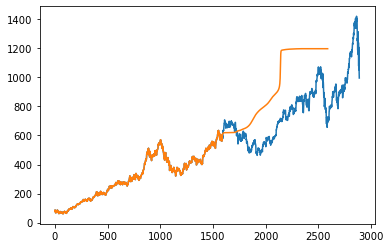

In [40]:
alldata = np.append(aaplmktcap, predictions)
sequence2 = np.append(aaplmktcap[:-1300], predictions)
plt.plot(aaplmktcap)
plt.plot(sequence2)

In [41]:
aaplmktcap = get_market_cap(prices, 'AAPL')
predictions = np.zeros((1000, 1))
data = np.array(aaplmktcap[-n_lag-n_trailing-500:-n_lag-500])
data = data.reshape(1, data.shape[0], 1)
print(data.shape)
for i in range(1000):
    predictions[i] = model.predict(data)
    data[:,:-1,:] = data[:,1:,:]
    data[:,-1:,:] = predictions[i]

(1, 180, 1)


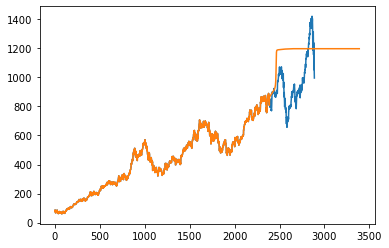

In [42]:
alldata = np.append(aaplmktcap, predictions)
sequence2 = np.append(aaplmktcap[:-500], predictions)
plt.plot(aaplmktcap)
plt.plot(sequence2)

In [52]:
aaplmktcap = get_market_cap(prices, 'AAPL')
predictions = np.zeros((1000, 1))
data = np.array(aaplmktcap[-n_lag-n_trailing+1:-n_lag+1])
data = data.reshape(1, data.shape[0], 1)
print(data.shape)
for i in range(1000):
    predictions[i] = model.predict(data)
    data[:,:-1,:] = data[:,1:,:]
    data[:,-1:,:] = predictions[i]

(1, 180, 1)


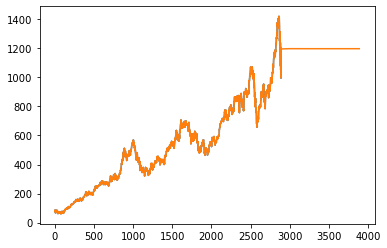

In [53]:
aaplmktcap = get_market_cap(prices, 'AAPL')
alldata = np.append(aaplmktcap, predictions)
sequence2 = np.append(aaplmktcap[:], predictions)
plt.plot(aaplmktcap)
plt.plot(sequence2)

In [45]:
aaplmktcap = get_market_cap(prices, 'AMZN')
predictions = np.zeros((1000, 1))
data = np.array(aaplmktcap[-n_lag-n_trailing-500:-n_lag-500])
data = data.reshape(1, data.shape[0], 1)
print(data.shape)
for i in range(1000):
    predictions[i] = model.predict(data)
    data[:,:-1,:] = data[:,1:,:]
    data[:,-1:,:] = predictions[i]

(1, 180, 1)


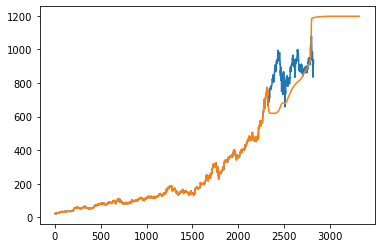

In [46]:
alldata = np.append(aaplmktcap, predictions)
sequence2 = np.append(aaplmktcap[:-500], predictions)
plt.plot(aaplmktcap)
plt.plot(sequence2)

#### Model Attempt 3

LSTM &#8594; Dense &#8594; LSTM &#8594; Dropout &#8594; Dense &#8594; Dense

In [53]:
def model3(T_x=T_x, n_values=1):
    
    """
    This model is loosely based off of model 1 and further expands upon the LSTM and dense layer combination.
    Achieves substantial results, but falls short as it has no predictive ability beyond time frame of known values based on model architecture.
    """
    
    X_input = Input(shape=(T_x, n_values))
    X = LSTM(units=128, return_sequences=True)(X_input) # defining in terms of X_input instead of X for the first LSTM due to error may be based on bug or edge case, see https://github.com/keras-team/keras/issues/11746
    X = TimeDistributed(Dense(units=256, activation='relu'))(X)
    X = LSTM(units=128, return_sequences=True)(X)
    X = Dropout(0.2)(X)
    X = TimeDistributed(Dense(units=64, activation='relu'))(X)
    outputs = TimeDistributed(Dense(units=1, activation='relu'))(X)
    
    model = Model(inputs=X_input, outputs=outputs)
    
    return model

In [54]:
model = model3(T_x=T_x)
# model.summary()

In [55]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [61]:
full_dataset, X, Y, ticker_set = prep_dataset(m)
model.fit(X[:1400], Y[:1400], batch_size=32, epochs=30)

Train on 1400 samples
Epoch 1/30
1400/1400 [==============================] - 27s 19ms/sample - loss: 599.5866 - mean_squared_error: 599.5866
Epoch 2/30
1400/1400 [==============================] - 23s 17ms/sample - loss: 552.4530 - mean_squared_error: 552.4529
Epoch 3/30
1400/1400 [==============================] - 23s 17ms/sample - loss: 521.9029 - mean_squared_error: 521.9028
Epoch 4/30
1400/1400 [==============================] - 23s 17ms/sample - loss: 496.0677 - mean_squared_error: 496.0677
Epoch 5/30
1400/1400 [==============================] - 23s 17ms/sample - loss: 477.0491 - mean_squared_error: 477.0490
Epoch 6/30
1400/1400 [==============================] - 23s 17ms/sample - loss: 459.5151 - mean_squared_error: 459.5151
Epoch 7/30
1400/1400 [==============================] - 23s 16ms/sample - loss: 449.0511 - mean_squared_error: 449.0511
Epoch 8/30
1400/1400 [==============================] - 23s 17ms/sample - loss: 437.9002 - mean_squared_error: 437.9001
Epoch 9/30
1400/14

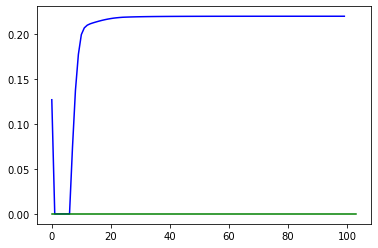

In [74]:
output = model.predict(X[1400:]) # make sure data input dimensions are aligned
rand = random.randint(0,99)
plt.plot(output[rand].reshape(T_x,1), 'b')
plt.plot(full_dataset[1400+rand], 'g')

In [182]:
print(output)

[[[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [-0.        ]
  [-0.        ]
  [-0.        ]]

 [[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [-0.        ]
  [-0.        ]
  [-0.        ]]

 [[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [ 0.15813439]
  [ 0.13774917]
  [ 0.13486812]]

 ...

 [[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [-0.        ]
  [-0.        ]
  [-0.        ]]

 [[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [ 7.154431  ]
  [ 6.975465  ]
  [ 6.809902  ]]

 [[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [-0.        ]
  [-0.        ]
  [-0.        ]]]


In [35]:
score = model.evaluate(X[1400:], Y[1400:])

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### Model Attempt 2

Defines the LSTM and dense layers and loops through hidden states and cell states

In [9]:
# define model layers

reshaper = Reshape((1, n_values))
LSTM_cell = LSTM(units=n_a, return_state=True) # default lstm cell, n_a is defined as a constant when initializing
denser = Dense(units=n_values, activation='relu') # dense layer for hidden state to output prediction, only one unit because there is only one predicted value

In [10]:
def model2(T_x=T_x, n_values=1):
    
    """
    1. take in input
    2. loop through timesteps
        a. extract timestep from timesteps for input
        b. reshape to (1, n_values)
        c. run the lstm to extract the hidden state and cell state
        d. dense layer
        e. output
    """
    
    # initialize input variables
    
    X = Input(shape=(T_x, n_values)) # 2D tensor input of timesteps and input variables
    a0 = Input(shape=(n_a, ), name='a0') # tensor of hidden activation states
    c0 = Input(shape=(n_a, ), name='c0') # tensor of cell states
    
    #initialize intermediary and output variables
    
    a = a0
    c = c0
    outputs = []
    
    # loop through timesteps
    
    for t in range(T_x):
        x = Lambda(lambda z: z[:, t, :])(X) # lambda works for keras tensor variables
        x = reshaper(x)
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        output = denser(a)
        outputs.append(output)
        
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return model

In [11]:
model = model2(T_x=T_x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 1)         0           lambda[0][0]                     
                                                                 lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]               

In [60]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [17]:
full_dataset, X, Y, ticker_set = prep_dataset(m)
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))
Y = list(Y.swapaxes(0, 1)) # super important for the output ordering!
model.fit([X, a0, c0], Y, batch_size=32, epochs=50)

KeyboardInterrupt: 

#### Model Attempt 1

1 LSTM layer and 1 time-distributed dense layer

In [4]:
# prices = np.reshape(prices, (prices.size, 1)) # unnecessary, but keeping just in case
# prices = np.array(prices) # also unnecessary
marketcap = prices[prices['Ticker']=='GOOG']['Price'] * prices[prices['Ticker']=='GOOG']['Shares'] / 1000000000
print(marketcap)

[187.67094708 188.18510485 375.65510014 ... 753.81538351 766.52330332
 736.99062003]


In [7]:
# test cell
# for i in get_market_cap(prices, 'AAPL'):
#     print(i)
print(prices[prices['Ticker']=='SHOP'])
print(set(prices['Ticker']))
print(len(set(prices['Ticker'])))

[]
{'SIVB', 'UIHC', 'TOWR', 'VIVE', 'FET', 'IHT', 'AHCP', 'STLD', 'CWS', 'ACLZ', 'RAVE', 'WIFI', 'QEBR', 'ZION', 'CVA', 'ICE', 'HALO', 'CNA', 'HCSG', 'NGL', 'ANF', 'KMI', 'BLCM', 'KORS', 'ALXN', 'CTXR', 'RLH', 'RKDA', 'CHEF', 'ABTX', 'BABY', 'ASPN', 'ABT', 'ELY', 'SCVL', 'CBL', 'AVGO', 'MNI', 'NHC', 'CHDN', 'REMI', 'ACN', 'MARK', 'PAA', 'TYL', 'AMT', 'RE', 'CNND', 'ADMA', 'CMRO', 'JCP', 'GFF', 'MCBC', 'MNRL', 'DDS', 'MEDF', 'RCII', 'SEAS', 'DY', 'PCMI', 'AVT', 'STRT', 'ALV', 'GOLF', 'WRK', 'ENDP_o', 'RCUS', 'MPWR', 'UPS', 'CLX', 'HDP', 'RFMD', 'HAR', 'NXST', 'SGMO', 'CMT', 'SNPS', 'FPH', 'ESV', 'ITNM', 'DKS', 'CRR', 'OXFD', 'SAAX', 'ALTR', 'ALPN', 'GPRO', 'IMGN', 'UIS', 'UHAL', 'MUX', 'FOX', 'HNI', 'ADOM', 'MOS', 'GE', 'PLPC', 'ICUI', 'PK', 'HURC', 'SAIC', 'LMT', 'PPSI', 'HRL', 'XHR', 'TTD', 'FICO', 'DHR', 'FII', 'CVX', 'PH', 'CPE', 'MSG', 'INCY', 'REI', 'M', 'YELP', 'MASI', 'CF', 'IFON', 'EPE', 'QLGC', 'PRSC', 'TPIC', 'AXL', 'AMC', 'TSRO', 'AVLR', 'SCI', 'VXRT', 'DMLP', 'AHS', 'KONA',

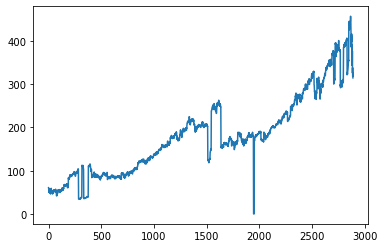

In [8]:
plt.plot(get_market_cap(prices, 'V'))

In [101]:
# attempt 1 at dataset preparation

stockset = list(set(prices['Ticker']))
# sampleset = ['AAPL', 'AMZN', 'MSFT', 'UAL', 'BA', 'TWTR', 'SQ', 'INTU']
sampleset = random.sample(stockset, k = 500)
print(sampleset)
sampledataset = np.zeros((len(sampleset), 500))
sampleresult = np.zeros((len(sampleset), 500))
for i, ticker in enumerate(sampleset):
    stockmktcap = get_market_cap(prices, ticker)
    days = stockmktcap.size
    sampledataset[i, 500-days:] = stockmktcap
    sampleresult[i,0:499] = sampledataset[i,1:500]
    sampleresult[i,499] = sampledataset[i,499]
sampledataset = sampledataset.reshape((sampledataset.shape[0], sampledataset.shape[1], 1))
sampleresult = sampleresult.reshape((sampleresult.shape[0], sampleresult.shape[1], 1))

In [13]:
# attempt 1 at model

def model(Tx, Ty):
    
    X = Input(shape=(Tx,1))
    a = LSTM(units=128, return_sequences=True)(X)
    a = TimeDistributed(Dense(units=32))(a)
    output = TimeDistributed(Dense(units=1))(a)
    
    model = Model(inputs=X, outputs=output)
    return model

In [43]:
sample = sampledataset[457].reshape(1,500,1)
plt.plot(model.predict(sample).reshape(500,1))
plt.plot(sampleresult[457])

In [120]:
# incomplete

def predict(Tx,Ty):
    X = Input(shape=(Tx,1))
    a = LSTM(units=32)

In [ ]:
output = model.predict([X, a0, c0])
# plt.plot(.reshape(T_x,1))
# plt.plot(sampleresult[4])